Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import Shapes_CNN as CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "/data/BGNN_data/Shapes/"

import os
import dataloader_shapes as dataLoader

Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Load images

In [4]:
import torchvision

# load images
datasetManager = dataLoader.datasetManager(experimentName)
dataset = datasetManager.getDataset()

file /data/BGNN_data/Shapes/dataset.pkl read


Create/Load model

In [5]:
import os

model = CNN.create_model()

train_loader, validation_loader, test_loader = datasetManager.getLoaders()
if os.path.exists(CNN.getModelFile(experimentName)):
    CNN.loadModel(model, experimentName)
    print("Model {0} loaded!".format(experimentName))
else:
    loss_list, accuracy_list, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, model, experimentName)

using a pretrained resnet model...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
    

Plot

Create confusion matrix

In [7]:
from confusion_matrix_plotter import generate_classification_report

predlist, lbllist = CNN.getLoaderPredictions(test_loader, model)

print(generate_classification_report(lbllist, predlist, 2, experimentName))

              precision    recall  f1-score   support

           0        1.0       0.9       0.9        10
           1        0.9       1.0       1.0        10

    accuracy                            1.0        20
   macro avg        1.0       0.9       0.9        20
weighted avg        1.0       0.9       0.9        20



In [8]:
# Which example you want to plot for?
exampleId = 99

shape = dataset[exampleId]['image'].shape
input_img = dataset[exampleId]['image'].view(1, shape[0], shape[1], shape[2])

In [9]:
out = model(input_img)
print(out)


tensor([[0.0153, 0.9847]], grad_fn=<SoftmaxBackward>)


In [10]:
for batch in test_loader:
    print(batch["fileName"])
    

['/data/BGNN_data/Shapes/Squares/7.jpg', '/data/BGNN_data/Shapes/Circles/24.jpg', '/data/BGNN_data/Shapes/Squares/43.jpg', '/data/BGNN_data/Shapes/Circles/46.jpg', '/data/BGNN_data/Shapes/Squares/10.jpg', '/data/BGNN_data/Shapes/Squares/4.jpg', '/data/BGNN_data/Shapes/Circles/23.jpg', '/data/BGNN_data/Shapes/Squares/24.jpg', '/data/BGNN_data/Shapes/Squares/23.jpg', '/data/BGNN_data/Shapes/Circles/4.jpg', '/data/BGNN_data/Shapes/Squares/27.jpg', '/data/BGNN_data/Shapes/Circles/33.jpg', '/data/BGNN_data/Shapes/Squares/46.jpg', '/data/BGNN_data/Shapes/Squares/33.jpg', '/data/BGNN_data/Shapes/Circles/10.jpg', '/data/BGNN_data/Shapes/Squares/32.jpg', '/data/BGNN_data/Shapes/Circles/43.jpg', '/data/BGNN_data/Shapes/Circles/27.jpg', '/data/BGNN_data/Shapes/Circles/32.jpg', '/data/BGNN_data/Shapes/Circles/7.jpg']


In [11]:
import os
from torchvision import transforms as torchvision_transforms
from skimage import io

from flashtorch_modefied import CNN_wrapper, visualizeOverlay, visualizeHeatmap, Backprop, visualizeAllClasses

def saliencyMap(fileName,listOfClasses = [0,1]):
    params = {"useHeirarchy": False}

    wrapped_model = CNN_wrapper(model, params)
    backprop = Backprop(wrapped_model)

    fig = plt.figure(figsize=(8, 2.5), dpi= 300)

    original = io.imread(os.path.join(experimentName, example_fileName))

    transforms = dataset.getTransforms()
    composedTransforms = torchvision_transforms.Compose(transforms)
    predictionImage = composedTransforms(original)

    if torch.cuda.is_available():
        predictionImage = predictionImage.cuda()

    predictionImage_tensor = predictionImage.unsqueeze(0).cpu()
    predictionImage_tensor.requires_grad = True
    heatmap = visualizeAllClasses(backprop, predictionImage_tensor, listOfClasses, guided=True, use_gpu=True)

    image2, cmap2, alpha2  = heatmap

#     image2 = torch.unsqueeze(image2, 2)
#     image2 = image2.repeat(1, 1, 3)

    plt.imshow(image2 .cpu().detach().numpy(), alpha=1, cmap = 'Blues') # [:, :, 2] Just showing each channel alone for now. might change later.
    plt.xticks([])
    plt.yticks([])

    fig.suptitle("Saliency map")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.show()
    fig.savefig(os.path.join(experimentName,"SaliencyMap_"+str(hash(fileName))+".pdf"))


    out = model(predictionImage_tensor.cuda())
    print(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.2270, 0.7730]], grad_fn=<SoftmaxBackward>)


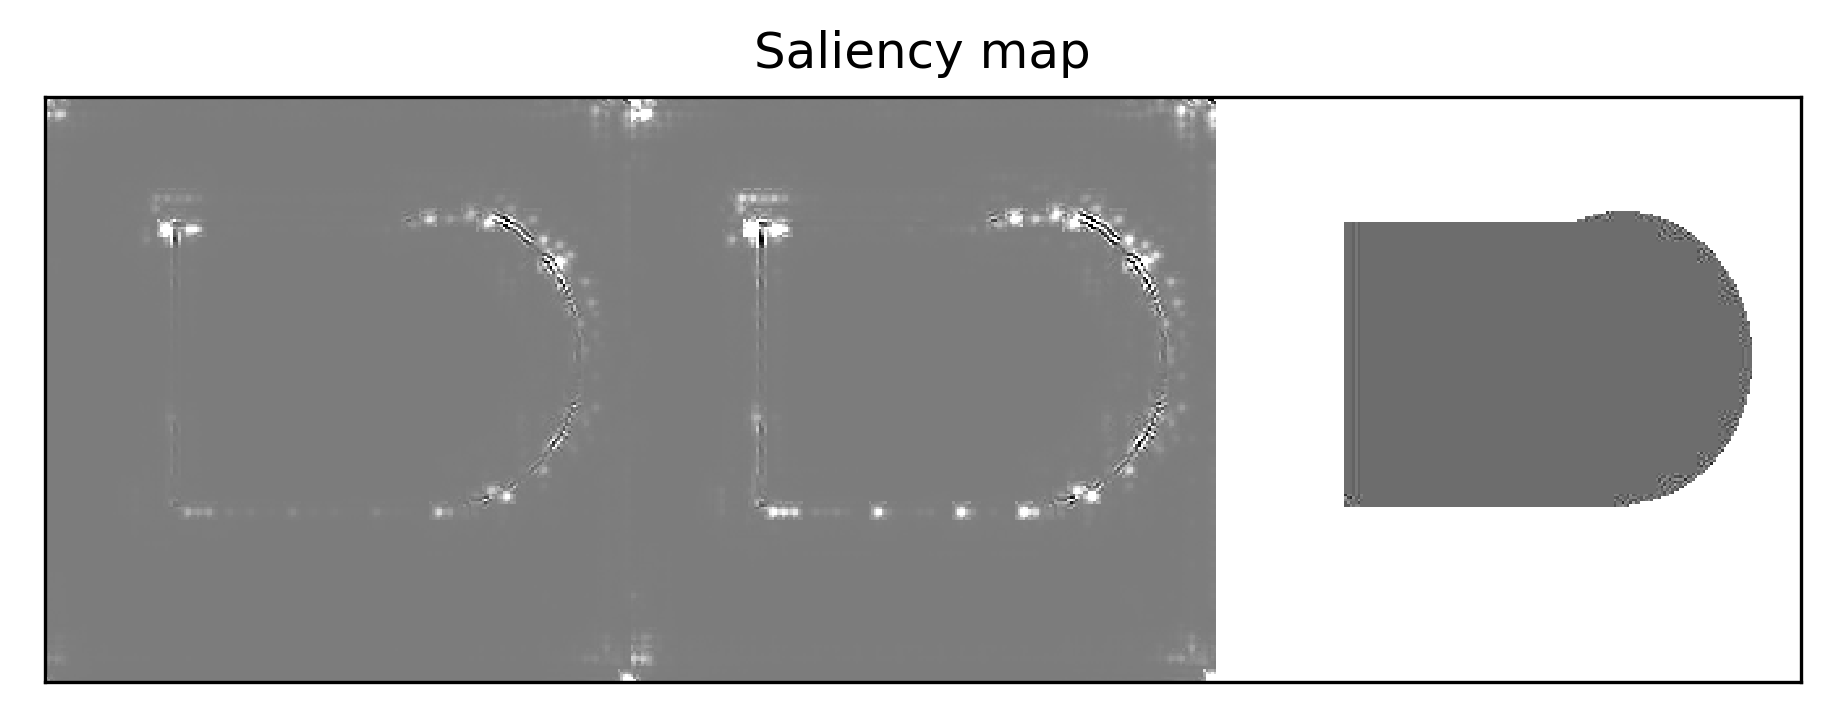

In [12]:
# params
example_fileName = "Squares/test6_23.jpg"
example_class = 1
saliencyMap(example_fileName)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.1071, 0.8929]], grad_fn=<SoftmaxBackward>)


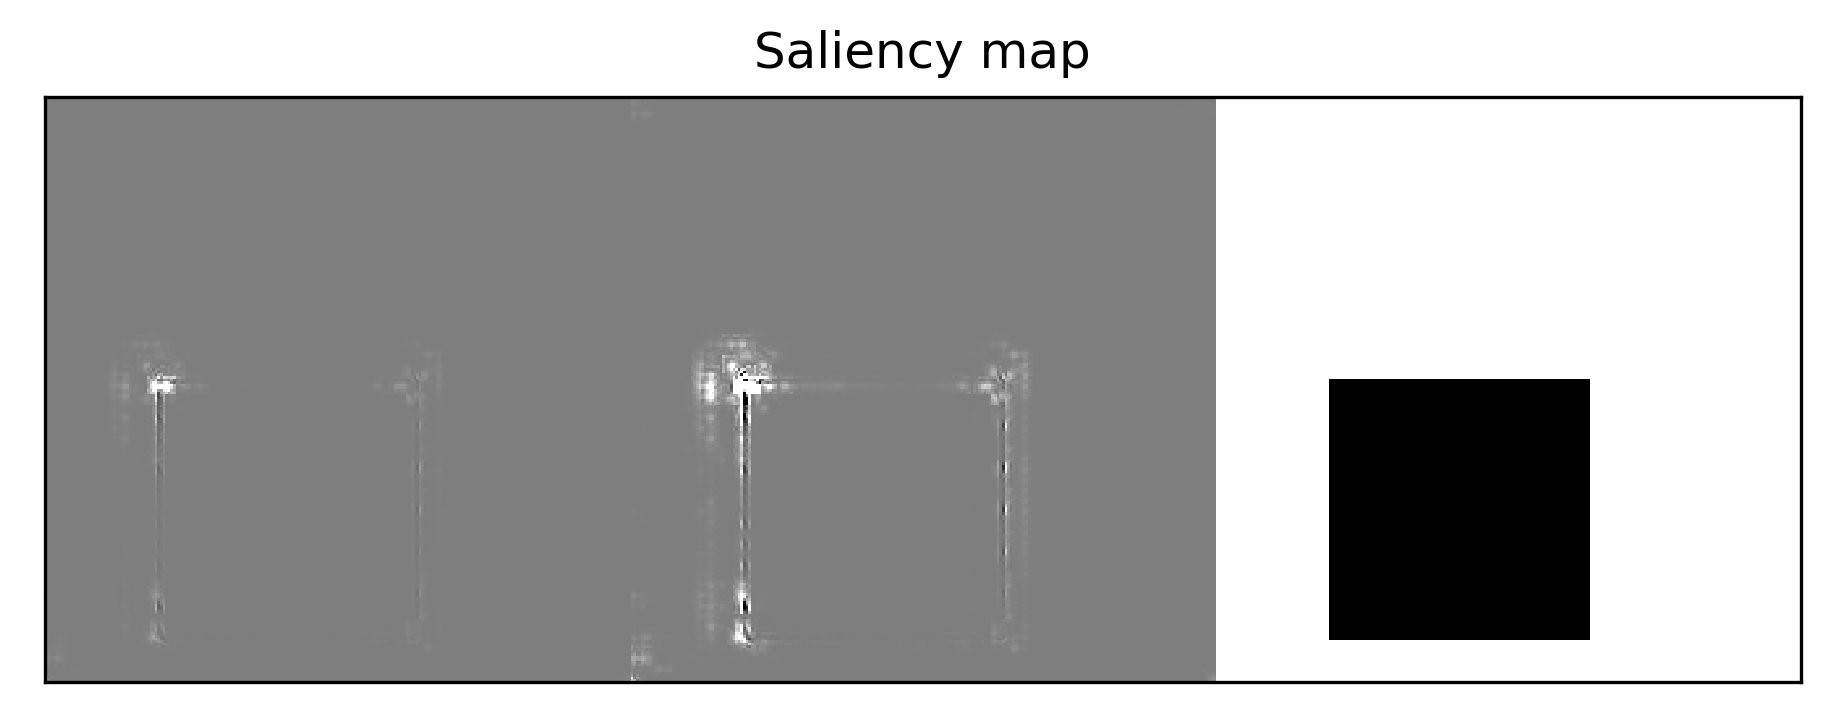

In [13]:
# params
example_fileName = "Squares/46.jpg"
saliencyMap(example_fileName)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.9875, 0.0125]], grad_fn=<SoftmaxBackward>)


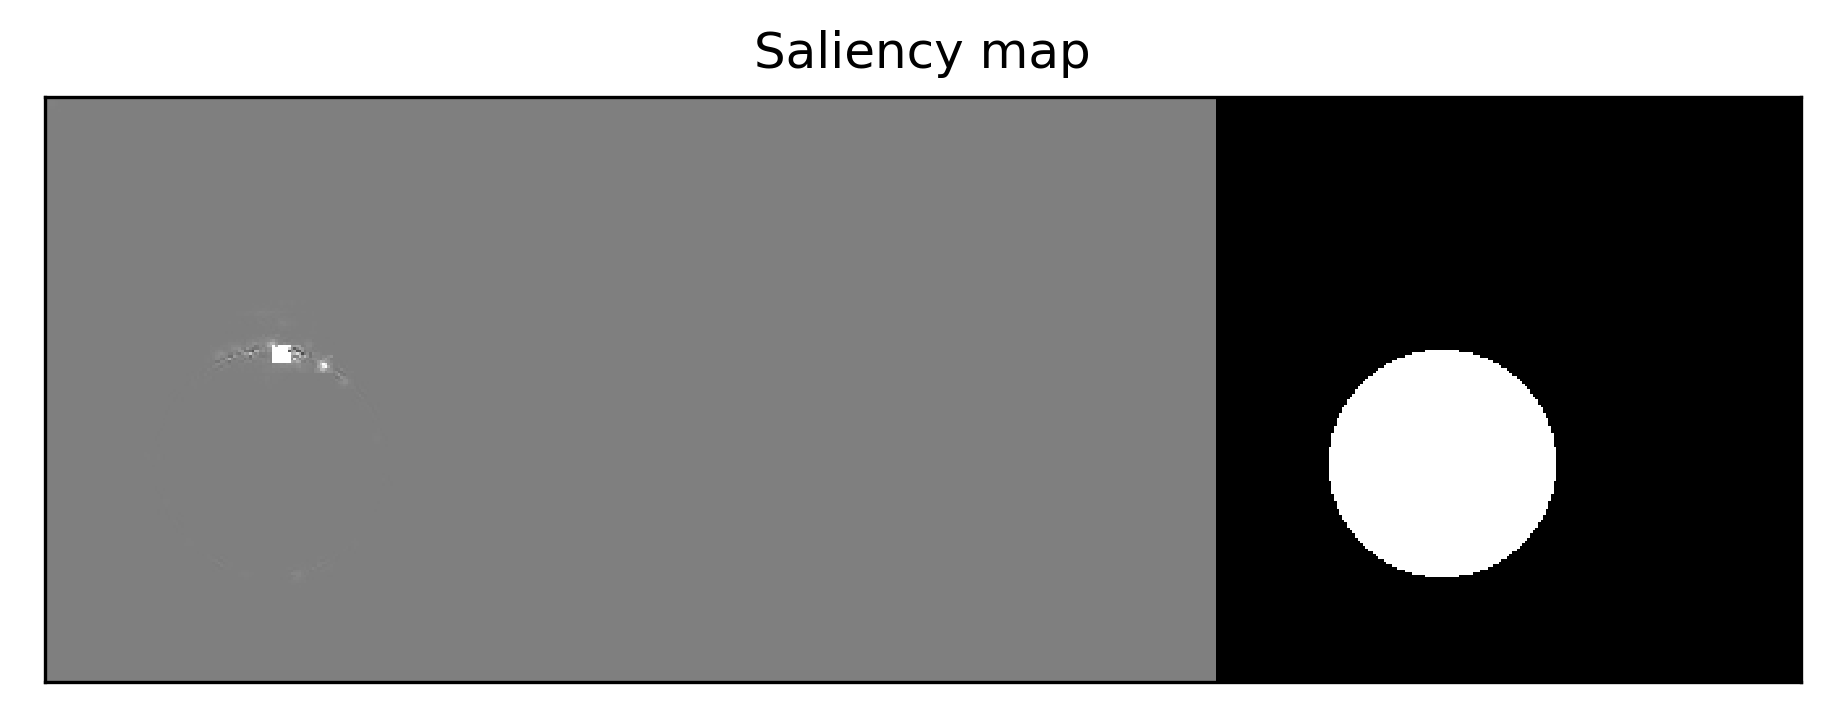

In [14]:
# params
example_fileName = "Circles/1.jpg"
saliencyMap(example_fileName)

In [15]:
# x = torch.tensor((2.0, 2.0), requires_grad = True)
# y = torch.zeros(3, 1)
# y[0] = x[0]**2
# y[1] = x[1]**3 - x[0]**2
# y[2] = -x[1]**3 + x[0]**2
# y=y[1]-y[2]
# y.backward(gradient=torch.ones(y.size()))
# print(x.grad)

tensor([-8., 24.])


In [16]:
# The devil is in the channels. 
# Each channel is kind of opposite for different classes. But, combining them together is hard to interpret.
# For this reason taking max across channels might not be meaningful.
# Remember that the gradients are local! They only say about minor perturbations. No implication on large class changes.
# clamping gradient to zero pre-standardization so image only show those pixels that contribute positively to a class.
